In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", color = "green", attrs = ["dark", "bold"]))

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>

LIBRARIES WERE SUCCESFULLY IMPORTED...


# LOAD DATASETS

In [2]:
train_set = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/train.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

test_set = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/test.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

print(colored("\nDATASETS WERE SUCCESFULLY LOADED...", color = "green", attrs = ["dark", "bold"]))


DATASETS WERE SUCCESFULLY LOADED...


**The first five rows of train set**

In [3]:
train_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


**The first five rows of test set**

In [4]:
test_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


**Shapes of the train and test sets**

In [5]:
print("Train set shape: {} and test set shape: {}".format(train_set.shape, test_set.shape))

Train set shape: (31962, 3) and test set shape: (17197, 2)


**Get general information about train set**

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


**Check whether there are duplicated values**

In [7]:
print("Totally there are {} duplicated values in train_set".format(train_set.duplicated().sum()))

Totally there are 0 duplicated values in train_set


**Get the number of classes of the "label" variable of train set</span>**

In [8]:
train_set.groupby("label").count().style.background_gradient(cmap = "summer")

,id,tweet
label,,
0,29720,29720
1,2242,2242


# CLEAN AND PROCESS DATASET

**Convert uppercase letters to lowercase letters in "tweet" columns**

In [9]:
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet"] = test_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nCONVERTED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


CONVERTED SUCCESFULLY...


**Delete punctuation marks from "tweet" columns**

In [10]:
train_set["tweet"] = train_set["tweet"].str.replace('[^\w\s]','')
test_set["tweet"] = test_set["tweet"].str.replace('[^\w\s]','')

print(colored("\nDELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DELETED SUCCESFULLY...


**Delete numbers from "tweet" columns**

In [11]:
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')

print(colored("\n NUMBERS DELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


 NUMBERS DELETED SUCCESFULLY...


**Delete stopwords from "tweet" columns**

In [12]:
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

print(colored("\nSTOPWORDS DELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


STOPWORDS DELETED SUCCESFULLY...


**Lemmatization. That is, we get the roots of the words in the "tweet" columns**

In [13]:
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

print(colored("\nDONE SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DONE SUCCESFULLY...


**Drop "id" column from datasets**

In [14]:
train_set = train_set.drop("id", axis = 1)
test_set = test_set.drop("id", axis = 1)

print(colored("\n'ID' COLUMNS DROPPED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


'ID' COLUMNS DROPPED SUCCESFULLY...


**Look at the latest condition of train set**

In [15]:
train_set.head(n = 10)

,label,tweet
0,0,user father dysfunctional selfish drag kid dys...
1,0,user user thanks lyft credit cant use cause do...
2,0,bihday majesty
3,0,model love u take u time urð ðððð ððð
4,0,factsguide society motivation
5,0,huge fan fare big talking leave chaos pay disp...
6,0,user camping tomorrow user user user user user...
7,0,next school year year examsð cant think ð scho...
8,0,love land allin cavs champion cleveland clevel...
9,0,user user welcome im gr


**Look at the latest condition of test set**

In [16]:
test_set.head(n = 10)

,tweet
0,studiolife aislife requires passion dedication...
1,user white supremacist want everyone see new â...
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes ð...
4,rd bihday amazing hilarious nephew eli ahmir u...
5,choose momtips
6,something inside dy ððâ eye ness smokeyeyes ti...
7,finishedtattooinkedinkloveitâï âïâïâïâï thanks...
8,user user user never understand dad left young...
9,delicious food lovelife capetown mannaepicure ...


**Divide datasets**

In [17]:
x = train_set["tweet"]
y = train_set["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

print(colored("\nDIVIDED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DIVIDED SUCCESFULLY...


# **VECTORIZE DATA**

**Count Vectors" method**

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**"TF-IDF" method**

In [19]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# BUILD MACHINE LEARNING MODELS

**Logistic regression model with "count-vectors" method**

In [20]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'count-vectors' method
Accuracy ratio:  0.9480686716300942


**Logistic regression model with "tf-idf" method**

In [21]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.9307072884012537


**ROC AUC (curvature)**

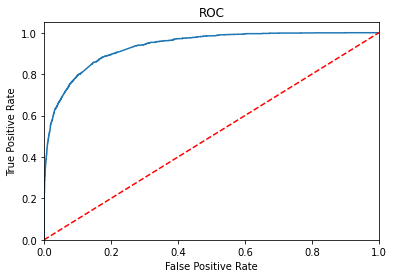

In [26]:
y = train_y
X = x_train_count.astype("float64")

logit_roc_auc = roc_auc_score(y, lgbm_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, lgbm_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

# ESTIMATION OVER TEST SET

# Look at the first 5 rows of the test set

In [27]:
test_set.head()

,tweet
0,studiolife aislife requires passion dedication...
1,user white supremacist want everyone see new â...
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes ð...
4,rd bihday amazing hilarious nephew eli ahmir u...


In [28]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
test_set = vectorizer.transform(test_set["tweet"])
test_set.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
lgbm_model.predict(test_set.astype("float"))[0:5]

array([0, 1, 0, 0, 0])

# VISUALIZATION WITH WORD CLOUD

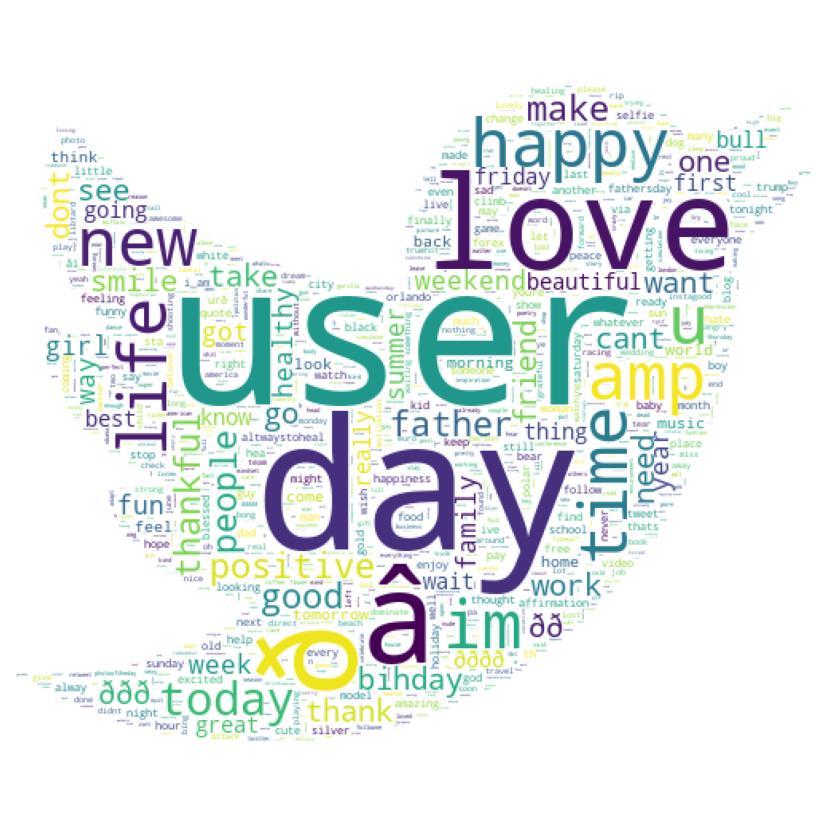

In [30]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

tw_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask3.jpg'))

text = " ".join(i for i in train_set.tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = tw_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.axis("off")
plt.show;

# Conclusion

* We trained logistic regression model using 'count-vector' and 'tf-idf'
* The model was fitted perfectly.
* With 'count-vector' we were able to get better accuracy score than 'tf-idf'
* we did word cloud visualization.